In [1]:
from pyspark.sql.functions import pandas_udf
from pyspark.sql.functions import PandasUDFType
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, BooleanType, LongType,ArrayType, DoubleType
from pyspark.sql import functions as F
from pyspark.sql.types import *
import pandas as pd
import time
from pyspark.sql.window import Window
import numpy as np
import datetime
import calendar
import matplotlib.pyplot as plt
import os
import iso3166

import matplotlib.ticker as plticker
from pyspark.sql.functions import monotonically_increasing_id 
import matplotlib.gridspec as gridspec
import random

In [2]:
# Imports
from importlib import reload
import os
import sys
import datetime
import time
import numpy as np
import hashlib
#import mysql.connector
import logging
import shutil
import random

#Stuff to Read Avro files
packages = '/home/sigga/spark-avro_2.12-3.0.0.jar'
os.environ["PYSPARK_SUBMIT_ARGS"] = ("--jars {0} pyspark-shell ".format(packages))


In [3]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession,SQLContext
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType,TimestampType,BooleanType,StringType, IntegerType,FloatType, DateType, DoubleType, StructType, StructField, LongType
from pyspark.sql import Window

# Create new context
spark = SparkSession.builder.config("spark.sql.files.ignoreCorruptFiles","true").config("spark.memory.fraction", "0.6").config("spark.sql.legacy.timeParserPolicy", "LEGACY").config("spark.driver.memory", "20g").config("spark.executor.memory","6g").config("spark.local.dir","/data/work/user/siggasvala/tmp/").master("local[15]").getOrCreate()


In [4]:
def SEMe(List):
    import math
    return (float(np.std(List))*float(np.sqrt(math.pi/2.0)))/float(np.sqrt(len(List)))
udf_SEMe = F.udf(SEMe,FloatType())

def median(List):
    return float(np.median(List))
udf_median = F.udf(median,FloatType())

def round_of_rating(number):
    """Round a number to the closest half integer.
    >>> round_of_rating(1.3)
    1.5
    >>> round_of_rating(2.6)
    2.5
    >>> round_of_rating(3.0)
    3.0
    >>> round_of_rating(4.1)
    4.0"""

    return round(number * 2) / 2
udf_round_of_rating = F.udf(round_of_rating,FloatType())

In [5]:
path = '/data/work/user/siggasvala/Sleep_away_from_home/Rebuttal/analysis_ready/'

df = spark.read.parquet(path)

### Pre-processing

In [6]:
cols = ["useruuid","weekend","home","onset_num","offset_num","sleep_duration_hours","duration_median"]
df = df.select(cols)
home = df.where(F.col("home")==True)
travel = df.where(F.col("home")==False)

In [7]:
user_home = home.groupby("useruuid","weekend").agg(F.collect_list("onset_num").alias("onset_list"),\
                                                   F.collect_list("offset_num").alias("offset_list"),\
                                                  F.collect_list("sleep_duration_hours").alias("duration_list"))
user_home = user_home.withColumn("onset_median",udf_median(F.col("onset_list"))).drop("onset_list")
user_home = user_home.withColumn("offset_median",udf_median(F.col("offset_list"))).drop("offset_list")
user_home = user_home.withColumn("duration_median",udf_median(F.col("duration_list"))).drop("duration_list")


user_travel = travel.groupby("useruuid","weekend").agg(F.mean("onset_num").alias("onset_avg_travel"),\
                                                       F.mean("offset_num").alias("offset_avg_travel"))


In [8]:
user_avg = user_home.join(user_travel,on=["useruuid","weekend"],how="inner")

In [9]:
user_avg.count()

33327

In [10]:
user_avg = user_avg.withColumn("delta_on",F.col("onset_avg_travel")-F.col("onset_median"))\
                   .withColumn("delta_off",F.col("offset_avg_travel")-F.col("offset_median"))
    

### Distribution of median duration + get percentiles for grouping in aggregate

In [48]:
duration_w = user_avg.where(F.col("weekend")==False).select("duration_median").toPandas().duration_median.tolist()
duration_f = user_avg.where(F.col("weekend")==True).select("duration_median").toPandas().duration_median.tolist()

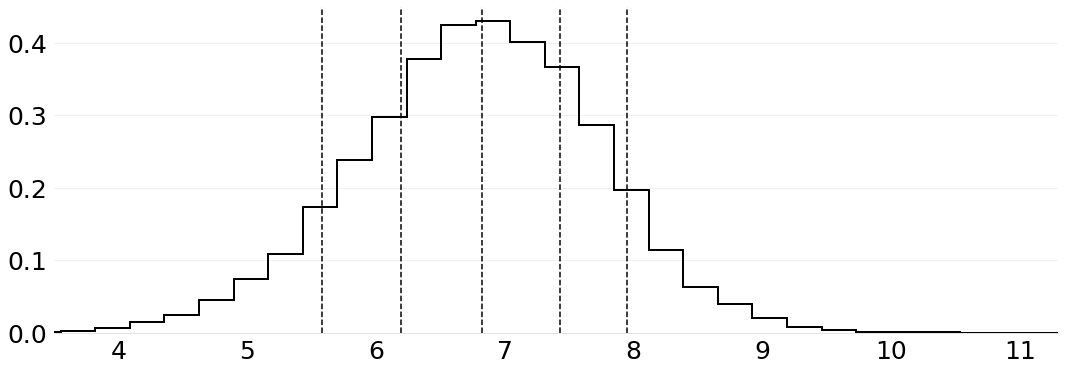

In [49]:
fig, axes = plt.subplots(1,1,figsize=(18,6))
props = dict(boxstyle='round', facecolor='white',  alpha=0.2)
C_home = "k"
C_travel = "#FD7B23"
boxprops = dict(linestyle='-', linewidth=4, color='indianred')

plt.hist(duration_w,histtype="step", bins=30, label="Home",color=C_home,edgecolor=C_home,density=1,lw=2)

for pp in [10,25,50,75,90]:
    dec_line = np.percentile(duration_w,pp)
    plt.axvline(x=float(dec_line),ls="--",color=C_home,lw=1.5,label=None)

locx = plticker.MultipleLocator(base=1) 
axes.xaxis.set_major_locator(locx)

# Axis styling.
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.spines['bottom'].set_color('#DDDDDD')
axes.tick_params(bottom=False, left=False)
axes.set_axisbelow(True)
axes.yaxis.grid(True, color='#EEEEEE')
axes.xaxis.grid(False)
axes.tick_params(axis='y', labelsize=25)
axes.tick_params(axis='x', labelsize=25)
axes.set_ylim([0,0.45])
axes.set_xlim([3.5,11.3])

path= "/home/sigga/sleep_away_from_home/Rebuttal Nature/dist_duration_home_weekdays.pdf"
fig.savefig(path, bbox_inches='tight')

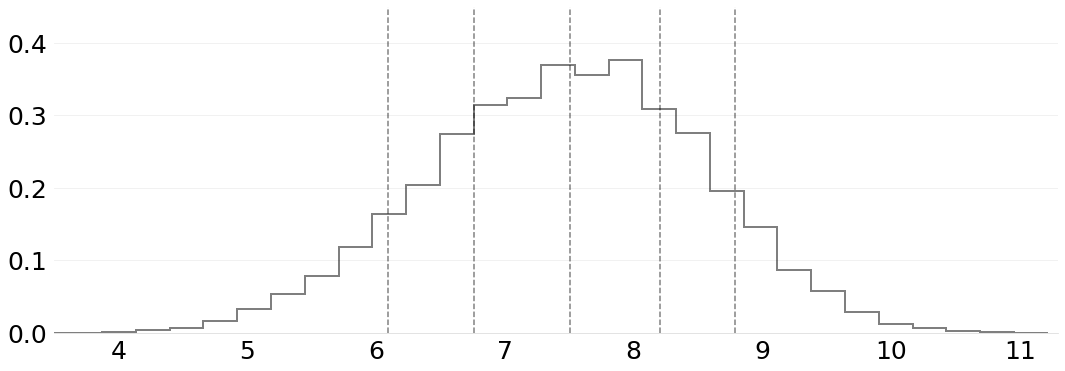

In [51]:
fig, axes = plt.subplots(1,1,figsize=(18,6))
props = dict(boxstyle='round', facecolor='white',  alpha=0.2)
C_home = "k"
C_travel = "#FD7B23"
boxprops = dict(linestyle='-', linewidth=4, color='indianred')

plt.hist(duration_f,histtype="step", bins=30, label="Home",color=C_home,edgecolor=C_home,alpha=0.5,density=1,lw=2)

for pp in [10,25,50,75,90]:
    dec_line = np.percentile(duration_f,pp)
    plt.axvline(x=float(dec_line),ls="--",color=C_home,alpha=0.5,lw=1.5,label=None)

#axes.set_xlim([-5.4,5.4])
#axes.set_ylim([0,75])
locx = plticker.MultipleLocator(base=1) 
axes.xaxis.set_major_locator(locx)

# Axis styling.
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.spines['bottom'].set_color('#DDDDDD')
axes.tick_params(bottom=False, left=False)
axes.set_axisbelow(True)
axes.yaxis.grid(True, color='#EEEEEE')
axes.xaxis.grid(False)
axes.tick_params(axis='y', labelsize=25)
axes.tick_params(axis='x', labelsize=25)
axes.set_ylim([0,0.45])
axes.set_xlim([3.5,11.3])
path= "/home/sigga/sleep_away_from_home/Rebuttal Nature/dist_duration_home_weekends.pdf"
fig.savefig(path, bbox_inches='tight')

### Aggregate by percentiles  

In [53]:
for pp in [10,25,50,75,90]:
    print(np.percentile(duration_w,pp))

5.583333492279053
6.191666603088379
6.824999809265137
7.433333396911621
7.949999809265137


In [54]:
for pp in [10,25,50,75,90]:
    print(np.percentile(duration_f,pp))

6.094999980926515
6.758333206176758
7.508333206176758
8.208333015441895
8.791666984558105


In [11]:
'''
WEEKDAYS:
[5.583333492279053
6.191666603088379
6.824999809265137
7.433333396911621
7.949999809265137] 
 
 WEEKENDS: 
[6.094999980926515
6.758333206176758
7.508333206176758
8.208333015441895
8.791666984558105]'''
def percentile_duration(median_duration,weekend):
    if weekend==False:
        if median_duration <5.58:
            return 1
        elif (median_duration >=5.58) & (median_duration<6.19):
            return 2
        elif (median_duration >=6.19) & (median_duration<6.82):
            return 3
        elif (median_duration >=6.82) & (median_duration<7.43):
            return 4
        elif (median_duration >=7.43) & (median_duration<7.95):
            return 5
        elif (median_duration >=7.95):
            return 6
    elif weekend==True:
        if median_duration <6.09:
            return 1
        elif (median_duration >=6.09) & (median_duration<6.76):
            return 2
        elif (median_duration >=6.76) & (median_duration<7.51):
            return 3
        elif (median_duration >=7.51) & (median_duration<8.21):
            return 4
        elif (median_duration >=8.21) & (median_duration<8.79):
            return 5
        elif (median_duration >=8.79):
            return 6
udf_percentile_duration = F.udf(percentile_duration,IntegerType())

In [12]:
user_avg = user_avg.withColumn("percentile_dur",udf_percentile_duration(F.col("duration_median"),F.col("weekend")))

In [13]:
perc_avg = user_avg.groupby("percentile_dur","weekend").agg(F.mean("delta_on").alias("delta_on"),\
                                                            F.stddev("delta_on").alias("delta_on_std"),\
                                                            F.mean("delta_off").alias("delta_off"),\
                                                            F.stddev("delta_off").alias("delta_off_std"),\
                                                            F.count("useruuid").alias("N"))


In [14]:
perc_avg = perc_avg.withColumn("SEM_on",F.col("delta_on_std")/F.sqrt(F.col("N")))\
                   .withColumn("SEM_off",F.col("delta_off_std")/F.sqrt(F.col("N")))

In [15]:
perc_avg = perc_avg.withColumn("delta_on",F.col("delta_on")*60)\
                   .withColumn("delta_off",F.col("delta_off")*60)\
                   .withColumn("SEM_on",F.col("SEM_on")*60)\
                   .withColumn("SEM_off",F.col("SEM_off")*60)

In [16]:
pd_plot = perc_avg.toPandas()

In [17]:
pd_plot = pd_plot.sort_values(by=["percentile_dur","weekend"],ascending=[True,True])

In [18]:
weekdays = pd_plot[pd_plot["weekend"]==False]
weekends = pd_plot[pd_plot["weekend"]==True]

In [22]:
weekdays

,percentile_dur,weekend,delta_on,delta_on_std,delta_off,delta_off_std,N,SEM_on,SEM_off
0,1,False,-18.892829,1.044514,33.248589,1.130624,1940,1.422868,1.540170
7,2,False,-4.300160,0.987973,26.675027,1.123142,2993,1.083535,1.231778
10,3,False,6.113670,0.965861,28.631584,1.137218,4942,0.824355,0.970608
4,4,False,16.388293,0.923543,27.504909,1.085778,4952,0.787441,0.925768
8,5,False,22.804595,0.916628,22.071264,1.095726,3049,0.996014,1.190624
3,6,False,29.344104,0.956660,7.367677,1.063422,1936,1.304537,1.450121


In [23]:
weekends

,percentile_dur,weekend,delta_on,delta_on_std,delta_off,delta_off_std,N,SEM_on,SEM_off
5,1,True,-29.845311,1.123743,-8.381389,1.087993,1343,1.839840,1.781309
6,2,True,-16.996620,1.079451,-18.214628,1.078885,2038,1.434671,1.433919
2,3,True,-6.433113,1.098715,-24.400680,1.032392,3395,1.131400,1.063105
11,4,True,1.483058,1.041217,-29.892235,1.026601,3368,1.076482,1.061371
9,5,True,13.200179,1.004290,-35.766240,0.990910,2011,1.343707,1.325804
1,6,True,24.539578,1.037748,-45.011380,0.987887,1360,1.688393,1.607270


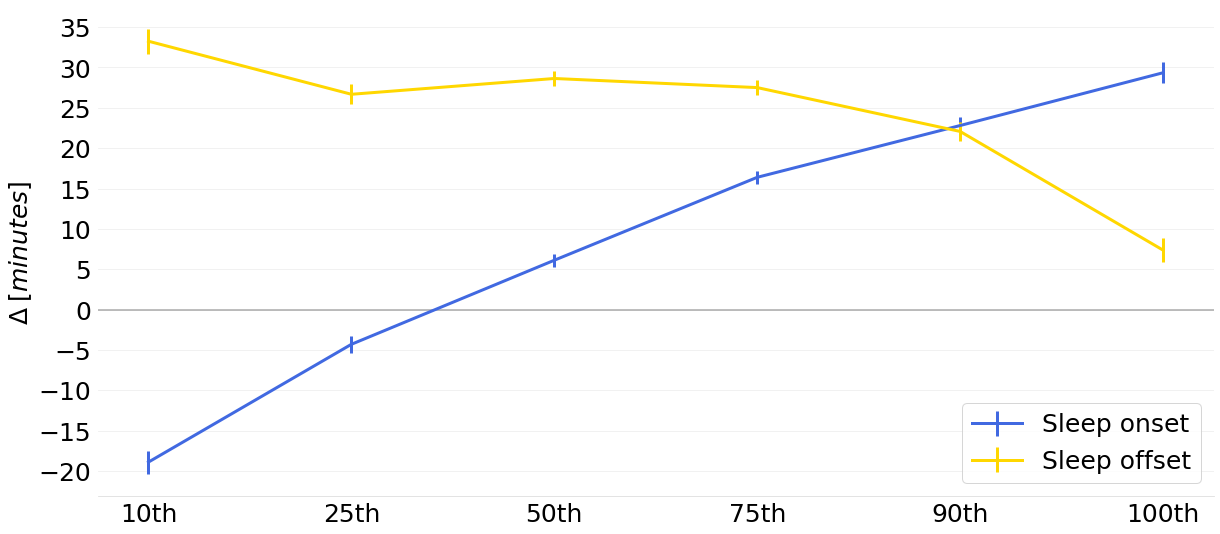

In [65]:
%matplotlib inline
fig, axes = plt.subplots(1,1,figsize=(20,9))

axes.errorbar(weekdays["percentile_dur"],weekdays["delta_on"],color="royalblue",fmt='-',yerr=weekdays["SEM_on"],lw=3,label="Sleep onset")
axes.errorbar(weekdays["percentile_dur"],weekdays["delta_off"],color="gold",fmt='-',yerr=weekdays["SEM_off"],lw=3,label="Sleep offset")

plt.axhline(y=0,ls="-",color="darkgrey",lw=1.5,label=None)

axes.set_ylabel(r'$\Delta \; [minutes]$ ',fontsize=25,color="k")

locy = plticker.MultipleLocator(base=5)
axes.yaxis.set_major_locator(locy)
axes.legend(prop={'size': 25},loc="lower right")
fig.savefig("overall.pdf", bbox_inches='tight')
axes.tick_params(axis='y', labelsize=25)
axes.tick_params(axis='x', labelsize=25)

# Axis styling.
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.spines['bottom'].set_color('#DDDDDD')
axes.tick_params(bottom=False, left=False)
axes.set_axisbelow(True)
axes.yaxis.grid(True, color='#EEEEEE')
axes.xaxis.grid(False)
plt.xticks([1,2,3,4,5,6],["10th","25th","50th","75th","90th","100th"])

fig.savefig("/home/sigga/sleep_away_from_home/Rebuttal Nature/delta_onset_offset_weekdays.pdf", bbox_inches='tight')


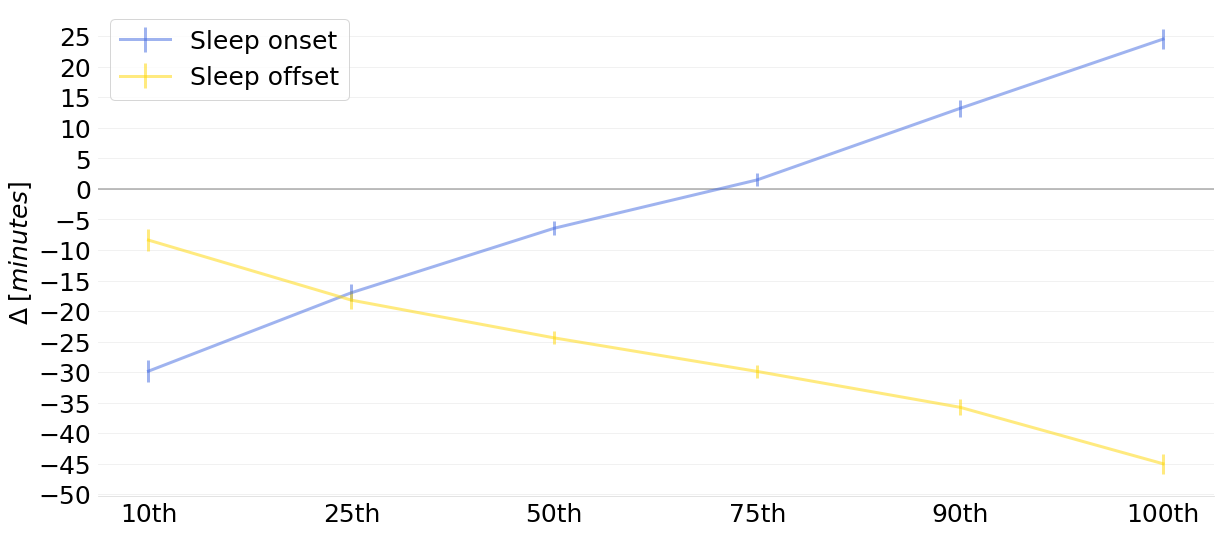

In [66]:
%matplotlib inline
fig, axes = plt.subplots(1,1,figsize=(20,9))

axes.errorbar(weekends["percentile_dur"],weekends["delta_on"],color="royalblue",fmt='-',yerr=weekends["SEM_on"],lw=3,alpha=0.5,label="Sleep onset")
axes.errorbar(weekends["percentile_dur"],weekends["delta_off"],color="gold",fmt='-',yerr=weekends["SEM_off"],lw=3,alpha=0.5,label="Sleep offset")

plt.axhline(y=0,ls="-",color="darkgrey",lw=1.5,label=None)

axes.set_ylabel(r'$\Delta \; [minutes]$ ',fontsize=25,color="k")

locy = plticker.MultipleLocator(base=5)
axes.yaxis.set_major_locator(locy)
axes.legend(prop={'size': 25},loc="upper left")
fig.savefig("overall.pdf", bbox_inches='tight')
axes.tick_params(axis='y', labelsize=25)
axes.tick_params(axis='x', labelsize=25)

# Axis styling.
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.spines['bottom'].set_color('#DDDDDD')
axes.tick_params(bottom=False, left=False)
axes.set_axisbelow(True)
axes.yaxis.grid(True, color='#EEEEEE')
axes.xaxis.grid(False)
plt.xticks([1,2,3,4,5,6],["10th","25th","50th","75th","90th","100th"])

fig.savefig("/home/sigga/sleep_away_from_home/Rebuttal Nature/delta_onset_offset_weekends.pdf", bbox_inches='tight')


## Distributions 

In [19]:
dist_plot = user_avg.select("weekend","delta_on","delta_off","percentile_dur").toPandas()

weekdays_wake = dist_plot[dist_plot["weekend"]==False].delta_off.tolist()
weekdays_bed = dist_plot[dist_plot["weekend"]==False].delta_on.tolist()

weekends_wake = dist_plot[dist_plot["weekend"]==True].delta_off.tolist()
weekends_bed = dist_plot[dist_plot["weekend"]==True].delta_on.tolist()

#### Overall weekdays

Average onset: 0.15831105397440878, Average offset 0.4236500773647054


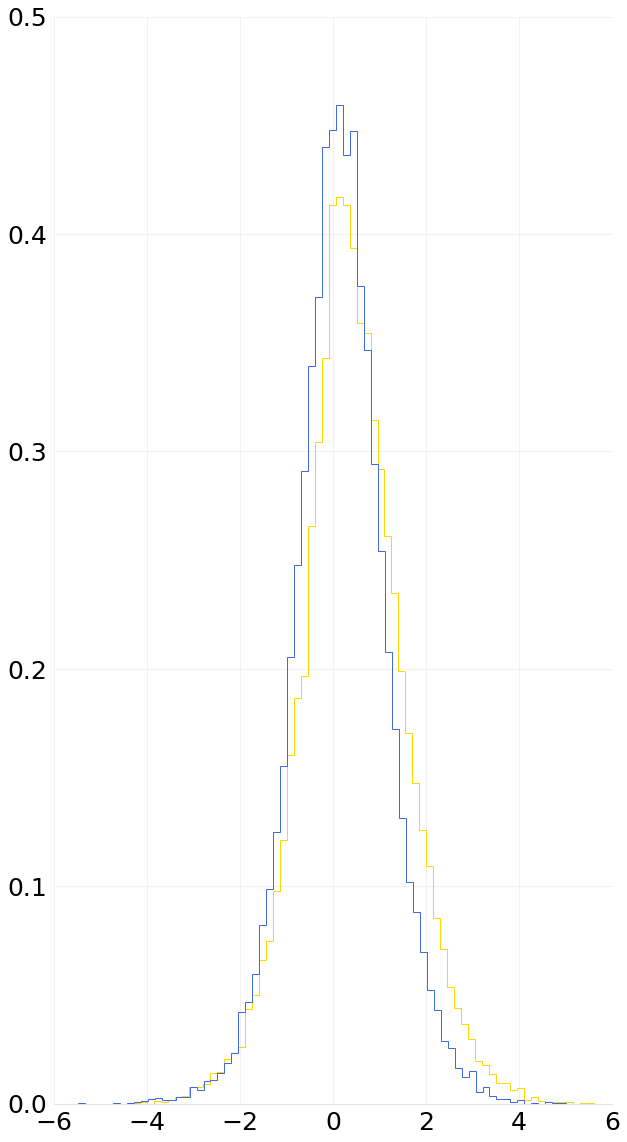

In [72]:
fig, axes = plt.subplots(1,1,figsize=(10,20))
props = dict(boxstyle='round', facecolor='white',  alpha=0.2)
C_home = "royalblue"
C_travel = "#FD7B23"
boxprops = dict(linestyle='-', linewidth=4, color='indianred')

binwidth = 0.15

bins_wake = list(np.arange(min(weekdays_wake), max(weekdays_wake) + binwidth, binwidth))
bins_bed = list(np.arange(min(weekdays_bed), max(weekdays_bed) + binwidth, binwidth))

plt.hist(weekdays_wake,histtype="step", bins=bins_wake, label="Wake-up time",color="gold",edgecolor="gold",density=1,lw=1)
plt.hist(weekdays_bed,histtype="step", bins=bins_bed, label="Bed time",color="royalblue",edgecolor="royalblue",density=1,alpha = 1,lw=1)


axes.set_xlim([-6,6])
axes.set_ylim([0,0.5])
locx = plticker.MultipleLocator(base=2) 
axes.xaxis.set_major_locator(locx)

# Axis styling.
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.spines['bottom'].set_color('#DDDDDD')
axes.tick_params(bottom=False, left=False)
axes.set_axisbelow(True)
axes.yaxis.grid(True, color='#EEEEEE')
axes.xaxis.grid(True, color='#EEEEEE')
axes.tick_params(axis='y', labelsize=25)
axes.tick_params(axis='x', labelsize=25)
fig.savefig("/home/sigga/sleep_away_from_home/Rebuttal Nature/dist_delta_on_off_weekdays.pdf", bbox_inches='tight')

print("Average onset: {}, Average offset {}".format(np.mean(weekdays_bed),np.mean(weekdays_wake)))

#### Weekdays percentile groups distribution 

Percentile 1: Average onset =-18.9 \; and \; average offset =33.249
Percentile 6: Average onset =29.3 \; and \; average offset =7.368


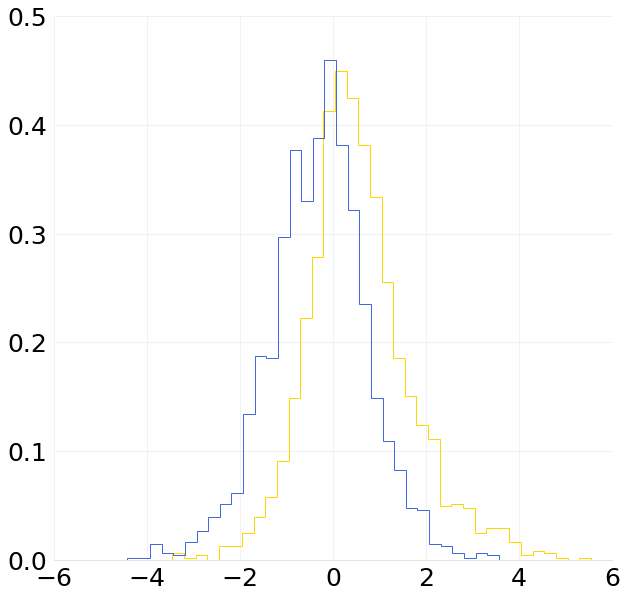

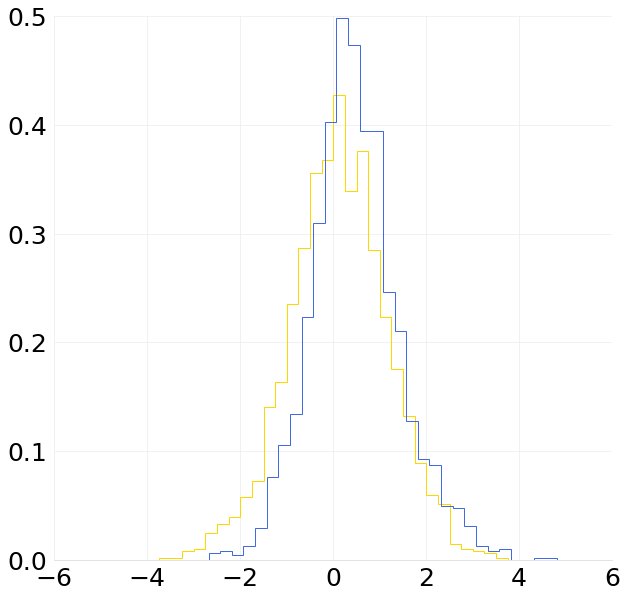

In [74]:
# Percentile groups 
perc = [1,6]
for p in perc:
    plot_df = dist_plot[(dist_plot["weekend"]==False) & (dist_plot["percentile_dur"]==p)]
    wake = plot_df.delta_off.tolist()
    bed = plot_df.delta_on.tolist()
    fig, axes = plt.subplots(1,1,figsize=(10,10))
    props = dict(boxstyle='round', facecolor='white',  alpha=0.2)
    
    boxprops = dict(linestyle='-', linewidth=4, color='indianred')

    binwidth = 0.25

    bins_wake = list(np.arange(min(wake), max(wake) + binwidth, binwidth))
    bins_bed = list(np.arange(min(bed), max(bed) + binwidth, binwidth))

    plt.hist(wake,histtype="step", bins=bins_wake,color="gold",edgecolor="gold",density=1,lw=1)
    plt.hist(bed,histtype="step", bins=bins_bed, color="royalblue",edgecolor="royalblue",density=1,lw=1)


    axes.set_xlim([-6,6])
    axes.set_ylim([0,0.5])
    locx = plticker.MultipleLocator(base=2) 
    axes.xaxis.set_major_locator(locx)

    # Axis styling.
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.spines['bottom'].set_color('#DDDDDD')
    axes.tick_params(bottom=False, left=False)
    axes.set_axisbelow(True)
    axes.yaxis.grid(True, color='#EEEEEE')
    axes.xaxis.grid(True, color='#EEEEEE')
    axes.tick_params(axis='y', labelsize=25)
    axes.tick_params(axis='x', labelsize=25)
    
    avg_on = round(float(np.mean(bed))*60,1)
    avg_off = round(float(np.mean(wake))*60,3)
    print('Percentile {0}: Average onset ={1} \; and \; average offset ={2}'.format(p,avg_on,avg_off))
    fig.savefig("/home/sigga/sleep_away_from_home/Rebuttal Nature/dist_delta_on_off_weekdays_perc{0}.pdf".format(str(p)), bbox_inches='tight')


### WEEKENDS

Average onset: -0.03902757254438808, Average offset -0.4501619882469169


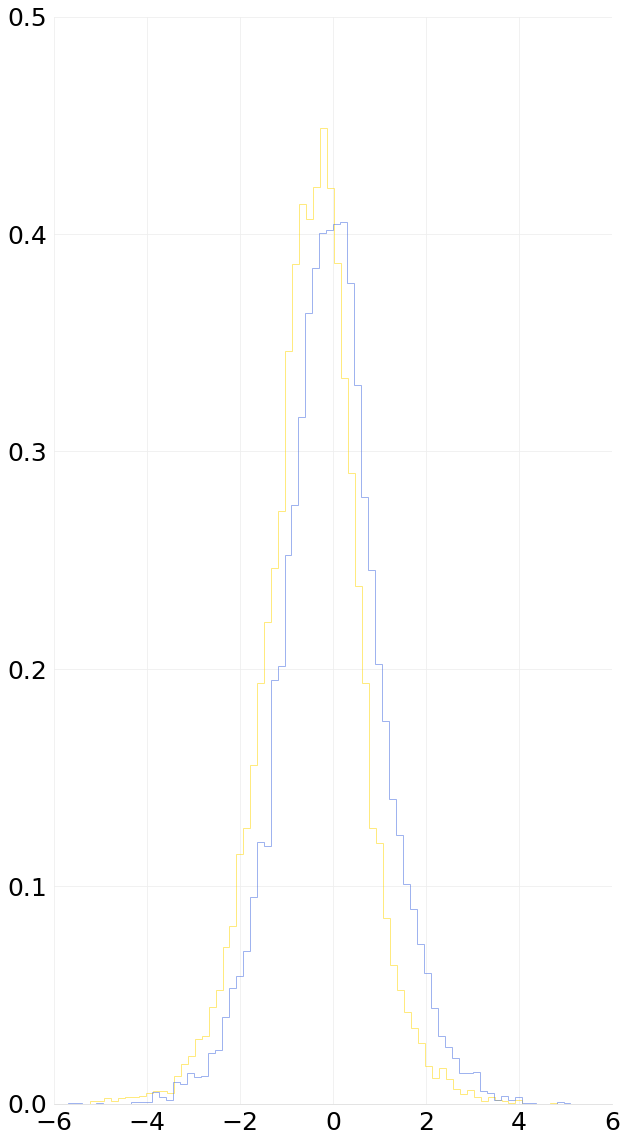

In [75]:
fig, axes = plt.subplots(1,1,figsize=(10,20))
props = dict(boxstyle='round', facecolor='white',  alpha=0.2)
C_home = "royalblue"
C_travel = "#FD7B23"
boxprops = dict(linestyle='-', linewidth=4, color='indianred')

binwidth = 0.15

bins_wake = list(np.arange(min(weekends_wake), max(weekdays_wake) + binwidth, binwidth))
bins_bed = list(np.arange(min(weekends_bed), max(weekdays_bed) + binwidth, binwidth))

plt.hist(weekends_wake,histtype="step", bins=bins_wake, label="Wake-up time",color="gold",edgecolor="gold",density=1,lw=1,alpha=0.5)
plt.hist(weekends_bed,histtype="step", bins=bins_bed, label="Bed time",color="royalblue",edgecolor="royalblue",density=1,alpha = 0.5,lw=1)


axes.set_xlim([-6,6])
axes.set_ylim([0,0.50])
locx = plticker.MultipleLocator(base=2) 
axes.xaxis.set_major_locator(locx)

# Axis styling.
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.spines['bottom'].set_color('#DDDDDD')
axes.tick_params(bottom=False, left=False)
axes.set_axisbelow(True)
axes.yaxis.grid(True, color='#EEEEEE')
axes.xaxis.grid(True, color='#EEEEEE')
axes.tick_params(axis='y', labelsize=25)
axes.tick_params(axis='x', labelsize=25)
fig.savefig("/home/sigga/sleep_away_from_home/Rebuttal Nature/dist_delta_on_off_weekends.pdf", bbox_inches='tight')

print("Average onset: {}, Average offset {}".format(np.mean(weekends_bed),np.mean(weekends_wake)))

### Weekend percentile groups

Percentile 1: Average onset=-29.8 and Average offset=-8.381
Percentile 6: Average onset=24.5 and Average offset=-45.011


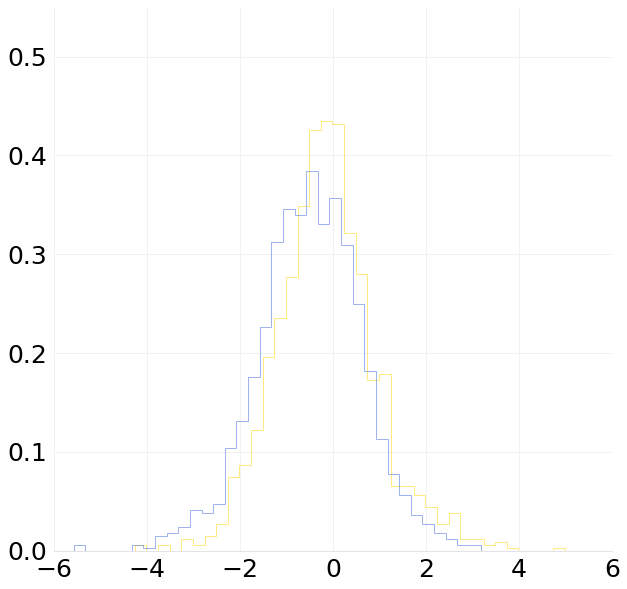

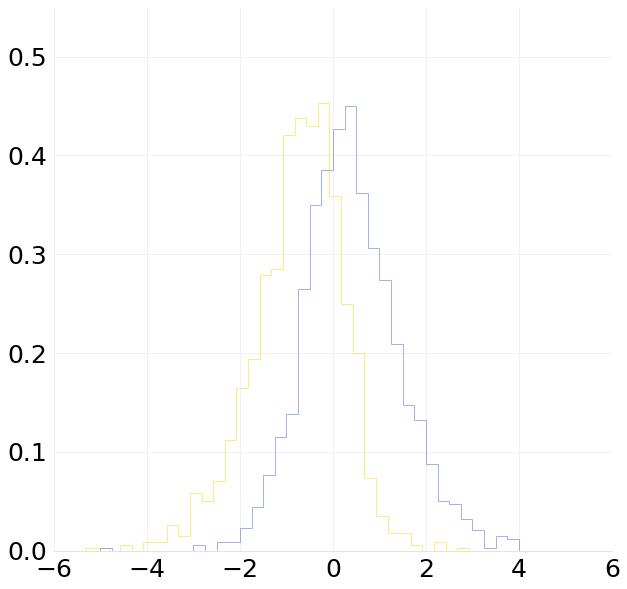

In [22]:
# Percentile groups 
perc = [1,6]
for p in perc:
    plot_df = dist_plot[(dist_plot["weekend"]==True) & (dist_plot["percentile_dur"]==p)]
    wake = plot_df.delta_off.tolist()
    bed = plot_df.delta_on.tolist()
    fig, axes = plt.subplots(1,1,figsize=(10,10))
    props = dict(boxstyle='round', facecolor='white',  alpha=0.2)
    
    boxprops = dict(linestyle='-', linewidth=4, color='indianred')

    binwidth = 0.25

    bins_wake = list(np.arange(min(wake), max(wake) + binwidth, binwidth))
    bins_bed = list(np.arange(min(bed), max(bed) + binwidth, binwidth))

    plt.hist(wake,histtype="step", bins=bins_wake,color="gold",edgecolor="gold",density=1,lw=1,alpha=0.5)
    plt.hist(bed,histtype="step", bins=bins_bed, color="royalblue",edgecolor="royalblue",density=1,lw=1,alpha=0.5)


    axes.set_xlim([-6,6])
    axes.set_ylim([0,0.55])
    locx = plticker.MultipleLocator(base=2) 
    axes.xaxis.set_major_locator(locx)

    # Axis styling.
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.spines['bottom'].set_color('#DDDDDD')
    axes.tick_params(bottom=False, left=False)
    axes.set_axisbelow(True)
    axes.yaxis.grid(True, color='#EEEEEE')
    axes.xaxis.grid(True, color='#EEEEEE')
    axes.tick_params(axis='y', labelsize=25)
    axes.tick_params(axis='x', labelsize=25)
    
    avg_on = round(float(np.mean(bed))*60,1)
    avg_off = round(float(np.mean(wake))*60,3)
    print('Percentile {0}: Average onset={1} and Average offset={2}'.format(p,avg_on,avg_off))
    fig.savefig("/home/sigga/sleep_away_from_home/Rebuttal Nature/dist_delta_on_off_weekends_perc{0}.pdf".format(str(p)), bbox_inches='tight')
